In [1]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
from torch import optim
from torch.utils.data import Subset, DataLoader, Dataset, random_split
from IPython.display import clear_output
from torchvision.transforms.v2 import Compose, ToDtype, Normalize, RandomAutocontrast, Resize, PILToTensor
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
import random
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import csv


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

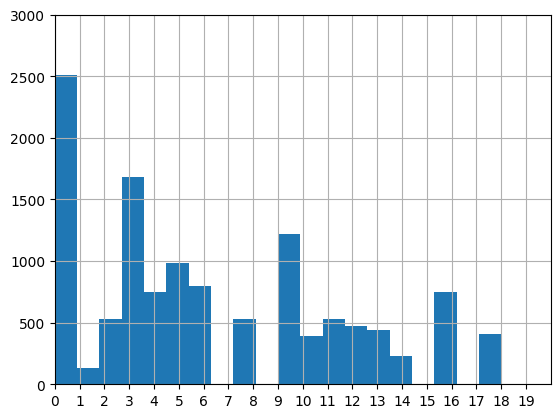

In [3]:
train_ans = pd.read_csv('human_poses_data/train_answers.csv')
vals = list(train_ans['target_feature'].values)

# plt.figure(figsize=(10, 3))
plt.axis((0, 20, 0, 3000))
plt.xticks(np.arange(0, 20, 1))
plt.grid(True)
plt.hist(train_ans['target_feature'].values, bins=20)
plt.show()

In [4]:
targets = list(map(int, train_ans['target_feature'].values))

index_to_target = []
for target in sorted(set(targets)):
    print(f'{target} - {targets.count(target)}')
    index_to_target.append(target)


print()
print(index_to_target)

0 - 2512
1 - 135
2 - 530
3 - 1680
4 - 752
5 - 982
6 - 800
8 - 533
9 - 1223
10 - 390
11 - 528
12 - 469
13 - 442
14 - 228
16 - 753
18 - 410

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18]


In [5]:
class Data():
    def __init__(self, image_dir, train, transform):
        """
        image_dir: путь к папке с изображениями
        transform: torchvision трансформации
        """
        self.image_dir = image_dir
        self.transform = transform
        self.train = train
        self.le = LabelEncoder()

        # Список всех файлов с нужными расширениями
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.endswith('.jpg')
        ]

        if self.train:
            train_ans = pd.read_csv('human_poses_data/train_answers.csv')
            label_map = dict(zip(train_ans['img_id'].values, train_ans['target_feature'].values))
            self.label_map = label_map

            # Преобразуем метки в плотный диапазон 0-15
            original_labels = list(label_map.values())
            encoded_labels = self.le.fit_transform(original_labels)
            self.label_map = dict(zip(label_map.keys(), encoded_labels))
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Загружаем изображение
        image = Image.open(img_path)
        image = self.transform(image)
            
        # Определяем метку по имени файла
        if self.train:
            label = self.label_map[int(img_name.split('.')[0])]
            return image, label
        else:
            return image
# from data.data import Data

In [6]:
transform = Compose([
    Resize((128, 228)),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25]),
    # Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_data = Data(image_dir="human_poses_data/img_train",
                 train=True,
                 transform=transform)

test_set = Data(image_dir="human_poses_data/img_test",
                 train=False,
                 transform=transform)


train_indices, valid_indices = train_test_split(
    range(len(train_data)),
    test_size=0.15,
    stratify=targets,
    random_state=42
)

# Создаем Subset'ы
train_set = Subset(train_data, train_indices)
valid_set = Subset(train_data, valid_indices)


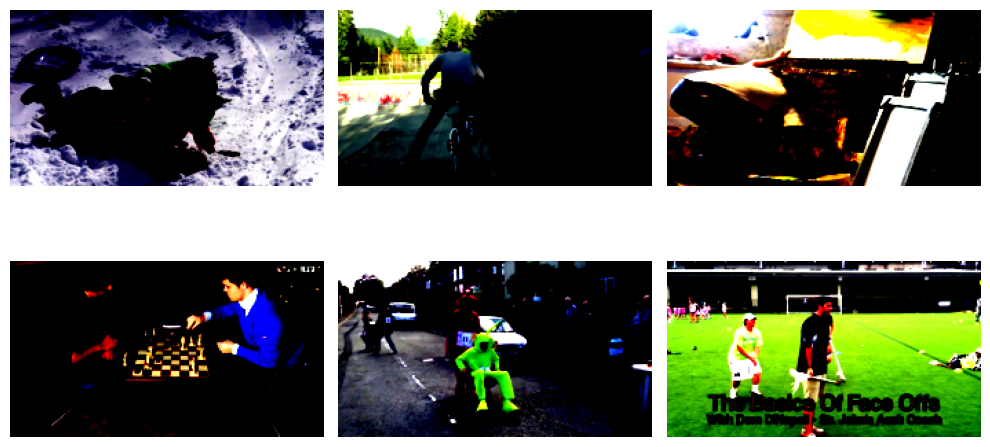

In [7]:
def show_dataset_images(dataset, num_images=6, cols=3):
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(10, 6))
    
    for i in range(num_images):
        image, _ = dataset[i]
        
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_dataset_images(train_set, num_images=6)


In [8]:
class BalancedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        
        self.class_indices = defaultdict(list)
        for i, (_, label) in enumerate(original_dataset):
            self.class_indices[label].append(i)
        
        self.all_indices = []
        self.is_augmented = []
        
        self.augmentations = [
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=np.random.uniform(5, 15)),
            v2.ColorJitter(
                brightness=np.random.uniform(0.1, 0.3),
                contrast=np.random.uniform(0.1, 0.3),
                saturation=np.random.uniform(0.1, 0.3),
                hue=np.random.uniform(0.05, 0.15)
            ),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        ]
        
        for label, indices in self.class_indices.items():
            current_count = len(indices)
            
            if current_count <= 300:
                needed = current_count * 5

            elif current_count <= 400:
                needed = current_count * 3

            elif current_count <= 500:
                needed = current_count * 2

            elif current_count <= 1000:
                needed = current_count

            elif current_count <= 1500:
                needed = int(current_count * 0.5)

            else:
                needed = 0
            
            self.all_indices.extend([(idx, 0) for idx in indices])
            
            if needed > 0:
                aug_indices = np.random.choice(indices, size=needed, replace=True)
                self.all_indices.extend([(idx, 1) for idx in aug_indices])
    
    def __len__(self):
        return len(self.all_indices)
    
    def __getitem__(self, idx):
        original_idx, is_augmented = self.all_indices[idx]
        image, label = self.original_dataset[original_idx]
        
        if is_augmented:
            num_augs = np.random.randint(1, 4)
            selected_augs = np.random.choice(self.augmentations, size=num_augs, replace=False).tolist()
            transform = v2.Compose(selected_augs)
            image = transform(image)
        
        return image, label
    
balanced_train_set = BalancedDataset(train_set)


In [9]:
len(balanced_train_set)

22812

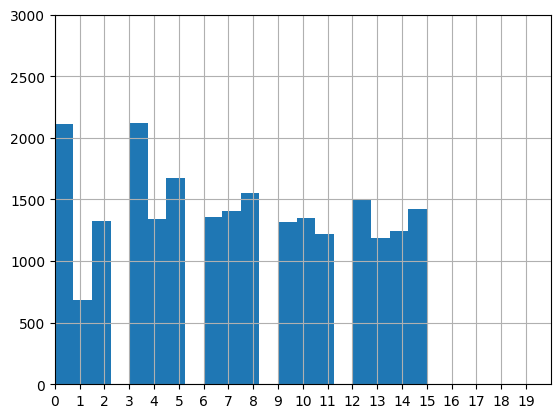

In [10]:
plt.axis((0, 20, 0, 3000))
plt.xticks(np.arange(0, 20, 1))
plt.grid(True)

targets = []
for _, target in balanced_train_set:
    targets.append(target)

plt.hist(targets, bins=20)
plt.show()

In [11]:
for target in sorted(set(targets)):
    print(f'{target} - {targets.count(target)}')


0 - 2113
1 - 684
2 - 1329
3 - 2124
4 - 1338
5 - 1674
6 - 1358
7 - 1404
8 - 1555
9 - 1316
10 - 1347
11 - 1218
12 - 1496
13 - 1188
14 - 1248
15 - 1420


In [12]:
# labels = [0, 0, 0, 1, 1, ...]  # Список всех меток
class_weights = compute_class_weight(
    "balanced", 
    classes=np.unique(targets), 
    y=targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


In [13]:
BATCH_SIZE = 100

train_loader = DataLoader(balanced_train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def show_losses(train, val, acc, f1):
    clear_output()
    plt.close('all')
    plt.figure(figsize=(12,4))
    
    PAST_EPOCHS = len(train)
    
    plt.subplot(1, 3, 1)
    plt.title("Loss values")
    plt.plot(np.arange(PAST_EPOCHS), train, color="b")
    plt.plot(np.arange(PAST_EPOCHS), val, color="orange")
    plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("Accuracy")
    plt.plot(np.arange(PAST_EPOCHS), acc, color="orange")
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("F1 score")
    plt.plot(np.arange(PAST_EPOCHS), f1, color="orange")
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.tight_layout()
    plt.show()

In [15]:
def run_epoch(model, dataloader, loss_function, optimizer=None):
    
    model.train() if optimizer is not None else model.eval()

    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.set_grad_enabled(optimizer is not None):
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_function(pred, y)

            total_loss += loss.item()

            if optimizer != None:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            else:
                all_preds.extend(pred.argmax(dim=1).cpu().numpy())
                all_targets.extend(y.cpu().numpy())

            
    avg_loss = total_loss / len(dataloader)
    
    if optimizer is None:
        acc = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='macro')
        return avg_loss, acc, f1
    else:
        return avg_loss, None, None


In [16]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels
        self.reduction_ratio = 8  # Во сколько раз сжимаем каналы для Q/K

        # 1x1 свёртки для Q, K, V (уменьшаем размерность для Q и K)
        self.query = nn.Conv2d(in_channels, in_channels // self.reduction_ratio, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // self.reduction_ratio, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)  # V без сжатия

        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling parameter

    def forward(self, x):
        B, C, H, W = x.shape
        
        # Получаем Q, K, V (с уменьшением каналов для Q и K)
        Q = self.query(x).view(B, -1, H * W).permute(0, 2, 1)  # (B, HW, C//8)
        K = self.key(x).view(B, -1, H * W)  # (B, C//8, HW)
        V = self.value(x).view(B, -1, H * W)  # (B, C, HW)

        # Attention матрица (лёгкая версия)
        attention = torch.bmm(Q, K)  # (B, HW, HW)
        attention = F.softmax(attention / (self.in_channels ** 0.5), dim=-1)

        # Взвешенная сумма
        out = torch.bmm(V, attention.permute(0, 2, 1))  # (B, C, HW)
        out = out.view(B, C, H, W)

        return self.gamma * out + x  # Skip-connection

In [18]:
class Model13(nn.Module):
    def __init__(self):
        super(Model13, self).__init__()

        self.block1 = nn.Sequential(  # (3, 128, 228)
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # (16, 128, 228)
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (16, 64, 114)
        )

        # (16, 64, 114)

        # --------------BigSkip--------------
        # --------------skip1--------------
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (32, 64, 114)
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 32, 57)

            nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32),  # Depthwise
            nn.Conv2d(32, 32, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(32),
            nn.PReLU(),

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 57)
            nn.BatchNorm2d(32),
            nn.PReLU(), # (32, 32, 57)
            nn.Dropout2d(0.2)
        )
        # --------------skip1--------------


        # --------------skip2--------------
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 32, 57)
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 16, 28)

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # (64, 16, 28)
            nn.BatchNorm2d(64),
            nn.PReLU(),
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 16, 28)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 8, 14)
        )
        # --------------skip2--------------


        # --------------skip3--------------
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (256, 8, 14)
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (256, 4, 7)
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # (256, 4, 7)
            nn.BatchNorm2d(256),
            nn.PReLU(),
        
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # (512, 4, 7)
            nn.BatchNorm2d(512),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (512, 2, 3)
        )
        # --------------skip3--------------
        # --------------BigSkip--------------

        # (512, 2, 3)



        self.skip1 = nn.Sequential(  # (16, 64, 114)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (32, 32, 57)
            nn.BatchNorm2d(32),
            nn.PReLU(),  # (32, 32, 57)
        )  # (32, 32, 57)

        self.skip2 = nn.Sequential(  # (32, 32, 57)
            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),  # (128, 16, 28)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 8, 14)
            SelfAttention(128),
        )
        
        self.skip3 = nn.Sequential(  # (128, 8, 14)
            nn.Conv2d(128, 512, kernel_size=3, stride=2, padding=1),  # (512, 4, 7) 
            nn.BatchNorm2d(512),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 2, 3)
            SelfAttention(512),
        )

        self.bigskip = nn.Sequential(  # (16, 64, 114)
            nn.Conv2d(16, 128, kernel_size=3, stride=2, padding=1),  # (128, 32, 57) 
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # (128, 16, 28) 

            nn.Conv2d(128, 512, kernel_size=3, stride=2, padding=1),  # (512, 8, 17) 
            nn.BatchNorm2d(512),
            nn.PReLU(),
            nn.AdaptiveAvgPool2d((2, 3)),  # (512, 2, 3)
            SelfAttention(512),
        )


        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512 * 2 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 16)
        )

    def forward(self, x):
        x = self.block1(x)
        bigskip = self.bigskip(x)

        skip = self.skip1(x)
        out = self.block2(x)
        x = skip + out

        out = self.block3(x)
        skip = self.skip2(x)
        x = skip + out

        out = self.block4(x)
        skip = self.skip3(x)
        x = skip + out + bigskip
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [19]:
model = Model13().to(device)
summary(model, input_size=(3, 128, 228))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 228]             448
             PReLU-2         [-1, 16, 128, 228]               1
         MaxPool2d-3          [-1, 16, 64, 114]               0
            Conv2d-4          [-1, 128, 32, 57]          18,560
       BatchNorm2d-5          [-1, 128, 32, 57]             256
             PReLU-6          [-1, 128, 32, 57]               1
         AvgPool2d-7          [-1, 128, 16, 28]               0
            Conv2d-8           [-1, 512, 8, 14]         590,336
       BatchNorm2d-9           [-1, 512, 8, 14]           1,024
            PReLU-10           [-1, 512, 8, 14]               1
AdaptiveAvgPool2d-11            [-1, 512, 2, 3]               0
           Conv2d-12             [-1, 64, 2, 3]          32,832
           Conv2d-13             [-1, 64, 2, 3]          32,832
           Conv2d-14            [-1, 51

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        alpha (Tensor): Веса классов размером [num_classes]. Например, torch.tensor([0.1, 0.9]).
        gamma (float): Параметр фокусировки (чем больше, тем сильнее акцент на сложных примерах).
        reduction (str): 'mean' или 'sum'.
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Проверка размеров
        if inputs.dim() > 2:
            inputs = inputs.view(inputs.size(0), inputs.size(1), -1)  # Для 2D-данных (например, изображений)
            inputs = inputs.transpose(1, 2)
            inputs = inputs.contiguous().view(-1, inputs.size(-1))  # [B*H*W, C]
        targets = targets.view(-1)  # [B*H*W]

        # Вычисляем cross-entropy
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')  # [B*H*W]
        pt = torch.exp(-ce_loss)  # p_t из формулы Focal Loss

        # Применяем веса классов (alpha)
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)
            alpha = alpha.gather(0, targets)  # Выбираем alpha для каждого класса в targets
            loss = alpha * (1 - pt)**self.gamma * ce_loss
        else:
            loss = (1 - pt)**self.gamma * ce_loss

        # Редукция
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

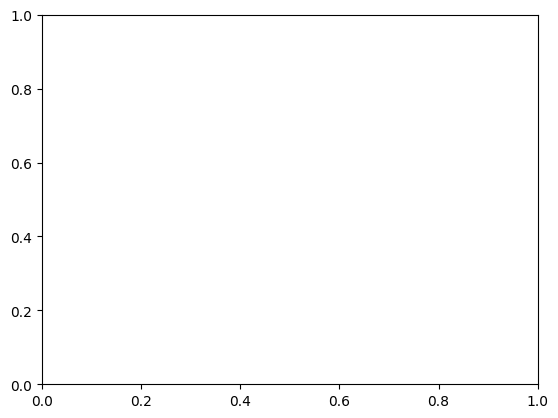

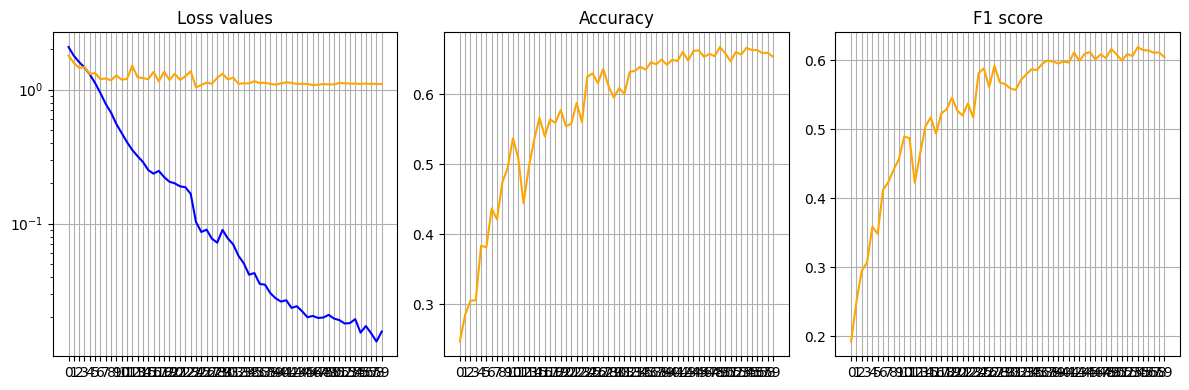

Current train loss: 0.01570
Current test loss: 1.09792

Current Accuracy: 0.65356 (max: 0.66756)
Current F1: 0.60430 (max: 0.61896)

Current LR: 1.5625e-05
Min loss: 1.0386092600069547
Max Accuracy: 0.6675646551724138
Max F1: 0.6189646290591293


In [21]:
NUM_EPOCHS = 60

#  Обучение модели
model = Model13().to(device)

# loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.001,
                           weight_decay=1e-4
                           )

loss_function = FocalLoss(alpha=class_weights, gamma=2.0).to(device)
    
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []

for i in range(NUM_EPOCHS):
    print(f"--------------Эпоха {i + 1}--------------")

    train_loss, acc, f1_ = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)

    test_loss, acc, f1_ = run_epoch(model, valid_loader, loss_function)
    test_loss_hist.append(test_loss)

    accuracy.append(acc)
    f1.append(f1_)
    
    scheduler.step(f1_)

    if f1[-1] == max(f1):
        torch.save(model, 'model13_best_model.pth')
        torch.save(model.state_dict(), 'model13_best_weights.pth')

    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)
    print(f"Current train loss: {train_loss_hist[-1]:.5f}")
    print(f"Current test loss: {test_loss_hist[-1]:.5f}\n")

    print(f"Current Accuracy: {accuracy[-1]:.5f} (max: {max(accuracy):.5f})")
    print(f"Current F1: {f1[-1]:.5f} (max: {max(f1):.5f})\n")

    print(f"Current LR: {optimizer.param_groups[0]['lr']}")



print(f"Min loss: {min(test_loss_hist)}")
print(f"Max Accuracy: {max(accuracy)}")
print(f"Max F1: {max(f1)}")

In [17]:
def predict(model, dataloader):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to('cpu')
            
            y_true += list(y)
            y_pred += list(torch.argmax(model(X), dim=1).cpu())
    return y_true, y_pred 

In [35]:
from sklearn.metrics import classification_report

y_true, y_pred = predict(model, valid_loader)

print(classification_report(y_true, y_pred))

100%|██████████| 19/19 [00:28<00:00,  1.50s/it]

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       399
           1       0.36      0.24      0.29        21
           2       0.51      0.43      0.47        87
           3       0.64      0.62      0.63       264
           4       0.62      0.76      0.68        83
           5       0.64      0.71      0.67       145
           6       0.66      0.70      0.68       121
           7       0.63      0.75      0.69        65
           8       0.80      0.77      0.78       186
           9       0.62      0.64      0.63        61
          10       0.60      0.63      0.61        79
          11       0.74      0.81      0.77        63
          12       0.51      0.37      0.43        68
          13       0.50      0.40      0.44        30
          14       0.71      0.64      0.67       129
          15       0.79      0.80      0.79        55

    accuracy                           0.67      1856
   macro avg       0.63   

In [36]:
model = torch.load('model11_best_model.pth', weights_only=False)

In [37]:
from sklearn.metrics import classification_report

y_true, y_pred = predict(model, valid_loader)

print(classification_report(y_true, y_pred))

100%|██████████| 19/19 [00:28<00:00,  1.47s/it]

              precision    recall  f1-score   support

           0       0.77      0.68      0.72       399
           1       0.36      0.24      0.29        21
           2       0.48      0.43      0.45        87
           3       0.63      0.61      0.62       264
           4       0.70      0.78      0.74        83
           5       0.60      0.69      0.64       145
           6       0.58      0.80      0.67       121
           7       0.65      0.80      0.72        65
           8       0.77      0.76      0.77       186
           9       0.63      0.66      0.65        61
          10       0.62      0.61      0.61        79
          11       0.77      0.79      0.78        63
          12       0.53      0.44      0.48        68
          13       0.56      0.50      0.53        30
          14       0.69      0.61      0.65       129
          15       0.74      0.84      0.79        55

    accuracy                           0.67      1856
   macro avg       0.63   

In [ ]:
# import torch
# torch.cuda.empty_cache()  

In [38]:
class Model14(nn.Module):
    def __init__(self):
        super(Model14, self).__init__()

        self.block1 = nn.Sequential(  # (3, 128, 228)
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (16, 64, 114)
        )

        # (16, 64, 114)

        # --------------BigSkip--------------
        # --------------skip1--------------
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (32, 64, 114)
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 32, 57)

            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # (32, 32, 57)
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.Dropout2d(0.2),
        )
        # --------------skip1--------------

        # (32, 32, 57)

        # --------------skip2--------------
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # (32, 32, 57)
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # (32, 32, 57)
            nn.BatchNorm2d(32),
            nn.PReLU(),
        )
        # --------------skip2--------------

        # (32, 32, 57)

        # --------------skip3--------------
        self.block4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 32, 57)
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 16, 28)

            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # (64, 16, 28)
            nn.BatchNorm2d(64),
            nn.PReLU(),
        )
        # --------------skip3--------------
        
        # (64, 16, 28)

        # --------------skip4--------------
        self.block5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # (64, 16, 28)
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Dropout2d(0.3),
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 16, 28)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 8, 14)
        )
        # --------------skip4--------------

        # (128, 8, 14)

        # --------------skip5--------------
        self.block6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # (128, 8, 14)
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 4, 7)
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # (256, 4, 7)
            nn.BatchNorm2d(256),
            nn.PReLU(),
        )
        # --------------skip5--------------

        # (256, 4, 7)

        # --------------skip6--------------
        self.block7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # (256, 4, 7)
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.Dropout2d(0.4),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # (512, 4, 7)
            nn.BatchNorm2d(512),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (512, 2, 3)
        )
        # --------------skip6--------------
        # --------------BigSkip--------------

        # (512, 2, 3)



        self.skip1 = nn.Sequential(  # (16, 64, 114)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (32, 32, 57)
            nn.BatchNorm2d(32),
            nn.PReLU(),  # (32, 32, 57)
        )  # (32, 32, 57)

        self.skip2 = nn.Sequential(  # (32, 32, 57)
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 57)
            nn.BatchNorm2d(32),
            nn.PReLU(),  # (32, 32, 57)
        )  # (32, 32, 57)

        self.skip3 = nn.Sequential(  # (32, 32, 57)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (64, 16, 28)
            nn.BatchNorm2d(64),
            nn.PReLU(),  # (64, 8, 14)
            nn.AdaptiveMaxPool2d((16, 28))
        )  # (64, 16, 28)
        
        self.skip4 = nn.Sequential(  # (64, 16, 28)
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128, 8, 14) 
            nn.BatchNorm2d(128),
            nn.PReLU(),  # (128, 8, 14)
        ) # (128, 8, 14)

        self.skip5 = nn.Sequential(  # (128, 8, 14)
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (128, 4, 7) 
            nn.BatchNorm2d(256),
            nn.PReLU(),
        )  # (256, 4, 7)
        
        self.skip6 = nn.Sequential(  # (256, 4, 7)
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # (128, 2, 3) 
            nn.BatchNorm2d(512),
            nn.PReLU(),
            nn.AdaptiveMaxPool2d((2, 3))
        )  # (512, 2, 3)

        self.bigskip = nn.Sequential(  # (16, 64, 114)
            nn.Conv2d(16, 128, kernel_size=3, stride=2, padding=1),  # (128, 32, 57) 
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # (128, 16, 28) 

            nn.Conv2d(128, 512, kernel_size=3, stride=2, padding=1),  # (512, 8, 17) 
            nn.BatchNorm2d(512),
            nn.PReLU(),
            nn.AdaptiveAvgPool2d((2, 3)),  # (512, 2, 3)
        )


        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512 * 2 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 16)
        )

    def forward(self, x):
        x = self.block1(x)
        bigskip = self.bigskip(x)

        skip = self.skip1(x)
        out = self.block2(x)
        x = skip + out

        out = self.block3(x)
        skip = self.skip2(x)
        x = skip + out

        out = self.block4(x)
        skip = self.skip3(x)
        x = skip + out

        out = self.block5(x)
        skip = self.skip4(x)
        x = skip + out

        out = self.block6(x)
        skip = self.skip5(x)
        x = skip + out
        
        out = self.block7(x)
        skip = self.skip6(x)
        x = skip + out + bigskip
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [39]:
model = Model14().to(device)
summary(model, input_size=(3, 128, 228))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 228]             448
       BatchNorm2d-2         [-1, 16, 128, 228]              32
             PReLU-3         [-1, 16, 128, 228]               1
         MaxPool2d-4          [-1, 16, 64, 114]               0
            Conv2d-5          [-1, 128, 32, 57]          18,560
       BatchNorm2d-6          [-1, 128, 32, 57]             256
             PReLU-7          [-1, 128, 32, 57]               1
         AvgPool2d-8          [-1, 128, 16, 28]               0
            Conv2d-9           [-1, 512, 8, 14]         590,336
      BatchNorm2d-10           [-1, 512, 8, 14]           1,024
            PReLU-11           [-1, 512, 8, 14]               1
AdaptiveAvgPool2d-12            [-1, 512, 2, 3]               0
           Conv2d-13           [-1, 32, 32, 57]           4,640
      BatchNorm2d-14           [-1, 32,

In [ ]:
NUM_EPOCHS = 70

#  Обучение модели
model = Model14().to(device)

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.001,
                           weight_decay=1e-4
                           )
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []

for i in range(NUM_EPOCHS):
    print(f"--------------Эпоха {i + 1}--------------")

    train_loss, acc, f1_ = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)

    test_loss, acc, f1_ = run_epoch(model, valid_loader, loss_function)
    test_loss_hist.append(test_loss)

    accuracy.append(acc)
    f1.append(f1_)
    
    scheduler.step(f1_)

    if f1[-1] == max(f1):
        torch.save(model, 'model14_best_model.pth')
        torch.save(model.state_dict(), 'model14_best_weights.pth')

    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)
    print(f"Current train loss: {train_loss_hist[-1]:.5f}")
    print(f"Current test loss: {test_loss_hist[-1]:.5f}\n")

    print(f"Current Accuracy: {accuracy[-1]:.5f} (max: {max(accuracy):.5f})")
    print(f"Current F1: {f1[-1]:.5f} (max: {max(f1):.5f})\n")

    print(f"Current LR: {optimizer.param_groups[0]['lr']}")


print()
print(f"Min loss: {min(test_loss_hist)}")
print(f"Max Accuracy: {max(accuracy)}")
print(f"Max F1: {max(f1)}")

--------------Эпоха 1--------------


  0%|          | 1/229 [00:12<48:03, 12.65s/it]


KeyboardInterrupt: 

In [25]:
from sklearn.metrics import classification_report

y_true, y_pred = predict(model, valid_loader)

print(classification_report(y_true, y_pred))

100%|██████████| 19/19 [00:40<00:00,  2.11s/it]

              precision    recall  f1-score   support

           0       0.70      0.60      0.65       399
           1       0.33      0.24      0.28        21
           2       0.44      0.40      0.42        87
           3       0.55      0.50      0.52       264
           4       0.54      0.67      0.60        83
           5       0.57      0.69      0.62       145
           6       0.52      0.64      0.58       121
           7       0.55      0.60      0.57        65
           8       0.81      0.63      0.71       186
           9       0.36      0.52      0.43        61
          10       0.49      0.56      0.52        79
          11       0.73      0.78      0.75        63
          12       0.40      0.34      0.37        68
          13       0.36      0.33      0.34        30
          14       0.61      0.67      0.64       129
          15       0.67      0.76      0.71        55

    accuracy                           0.59      1856
   macro avg       0.54   

In [16]:
model = torch.load('model4_16_best_model.pth', weights_only=False)


In [23]:
from sklearn.metrics import classification_report

y_true, y_pred = predict(model, valid_loader)

print(classification_report(y_true, y_pred))

100%|██████████| 19/19 [00:29<00:00,  1.56s/it]

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       399
           1       0.23      0.90      0.37        21
           2       0.96      0.90      0.93        87
           3       0.92      0.95      0.93       264
           4       0.93      1.00      0.97        83
           5       0.99      0.92      0.95       145
           6       0.94      0.98      0.96       121
           7       0.91      0.92      0.92        65
           8       0.98      0.95      0.97       186
           9       0.00      0.00      0.00        61
          10       0.00      0.00      0.00        79
          11       0.00      0.00      0.00        63
          12       0.00      0.00      0.00        68
          13       0.00      0.00      0.00        30
          14       0.00      0.00      0.00       129
          15       0.00      0.00      0.00        55

    accuracy                           0.70      1856
   macro avg       0.49   


z:\projects\Yandex Kaggle\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
z:\projects\Yandex Kaggle\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
z:\projects\Yandex Kaggle\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
model.eval()
test_preds = []
test_ids = []

with torch.no_grad():
    for img_name in tqdm(test_set.image_files):
        img_path = os.path.join(test_set.image_dir, img_name)
        image = Image.open(img_path)
        image = test_set.transform(image)
        
        output = model(image.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
        
        test_ids.append(img_name.split('.')[0])
        test_preds.append(pred.item())

test_ids, test_preds = zip(*sorted(zip(test_ids, test_preds), key=lambda x: int(x[0])))

with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'target_feature'])
    writer.writerows(zip(test_ids, [index_to_target[p] for p in test_preds]))


100%|██████████| 5301/5301 [02:00<00:00, 44.17it/s]
